# Round trip and spot-checking the tuned model

January 2022

gully


In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import PhoenixEmulator, SparsePhoenixEmulator
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
import numpy as np
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cpu'

### Make a tensor composed of $N_{lines}$ sparsely spaced spectral lines.

I have experimentally verified that this notebook works with up to 500,000 lines.  You may wish to turn off overplotting all the lines for $N_{lines}>500$.  Also, the amplitudes become unphysical and the spectrum can become negative because we are adding flux loss and not opacity.

In [4]:
spectrum = PHOENIXSpectrum(teff=4700, logg=4.5)#, wl_lo=8019, wl_hi=12845)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

In [5]:
active_lower, active_upper = 8079, 12785
line_threshold_lower, line_threshold_upper = 8049, 12815

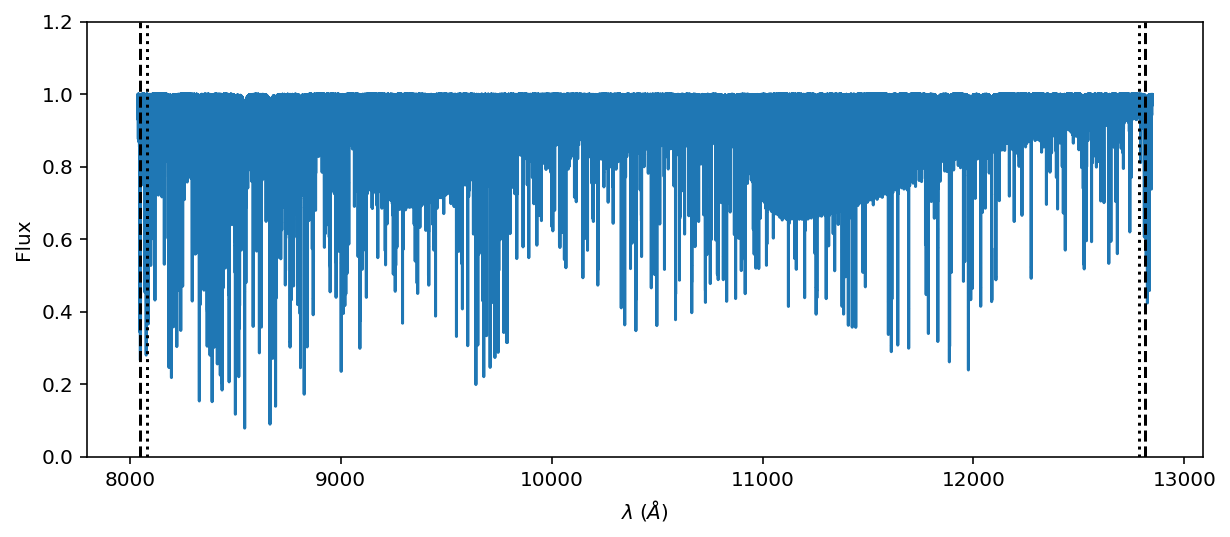

In [6]:
ax = spectrum.plot(ylo=0);
ax.axvline(8049, linestyle='dashed', color='k')
ax.axvline(12815, linestyle='dashed', color='k')

ax.axvline(8079, linestyle='dotted', color='k')
ax.axvline(12785, linestyle='dotted', color='k');

In [7]:
# Numpy arrays: 1 x N_pix
wl_native = spectrum.wavelength.value
flux_native = spectrum.flux.value

In [8]:
emulator = SparsePhoenixEmulator(wl_native, flux_native, prominence=0.02)

100%|███████████████████████████████████████| 6464/6464 [01:24<00:00, 76.34it/s]


In [9]:
state_dict_init = emulator.state_dict()

In [10]:
state_dict_init['lam_centers'].shape

torch.Size([6464])

In [11]:
state_dict_post = torch.load('../examples/sparse_T4700g4p5_prom0p02_HPF.pt')

In [12]:
emulator.load_state_dict(state_dict_post)

<All keys matched successfully>

In [21]:
with torch.no_grad():
    spec_out = emulator.forward().numpy()

In [22]:
wl = emulator.wl_native[emulator.active_mask].numpy()
flux = emulator.flux_native[emulator.active_mask].numpy()

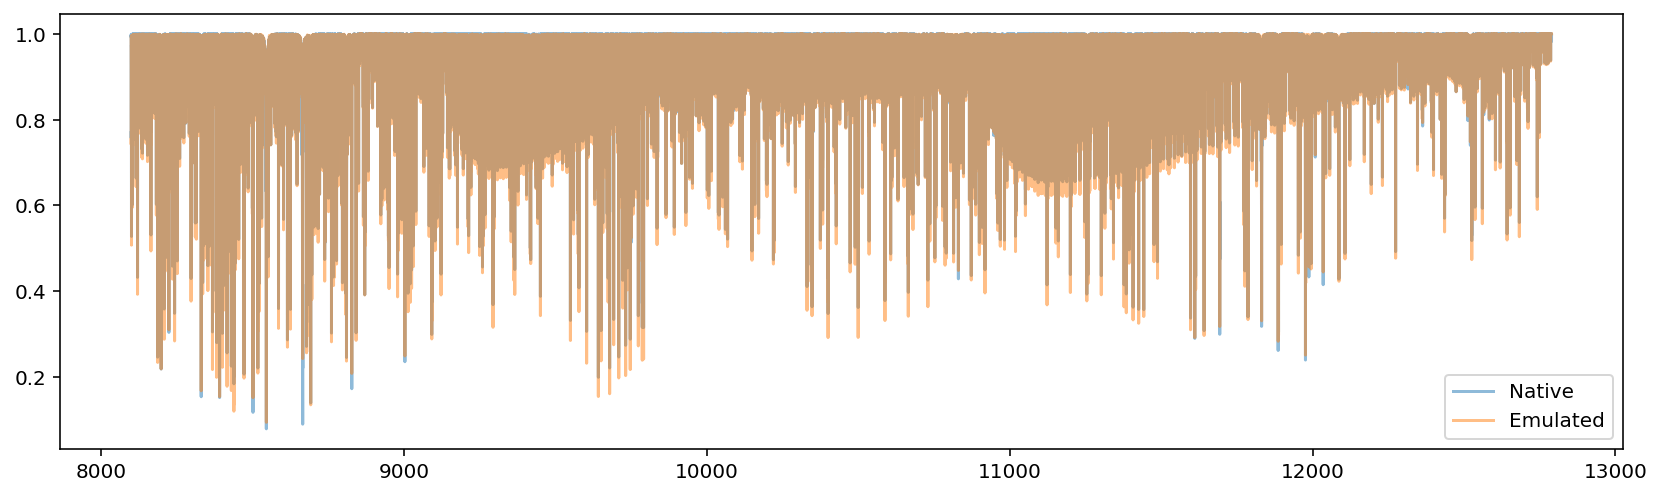

In [25]:
plt.figure(figsize=(14, 4))
plt.plot(wl, flux, alpha=0.5, label = 'Native')
plt.plot(wl, spec_out, alpha=0.5, label = 'Emulated')
plt.legend();

In [30]:
residual = flux - spec_out

(-0.1, 0.1)

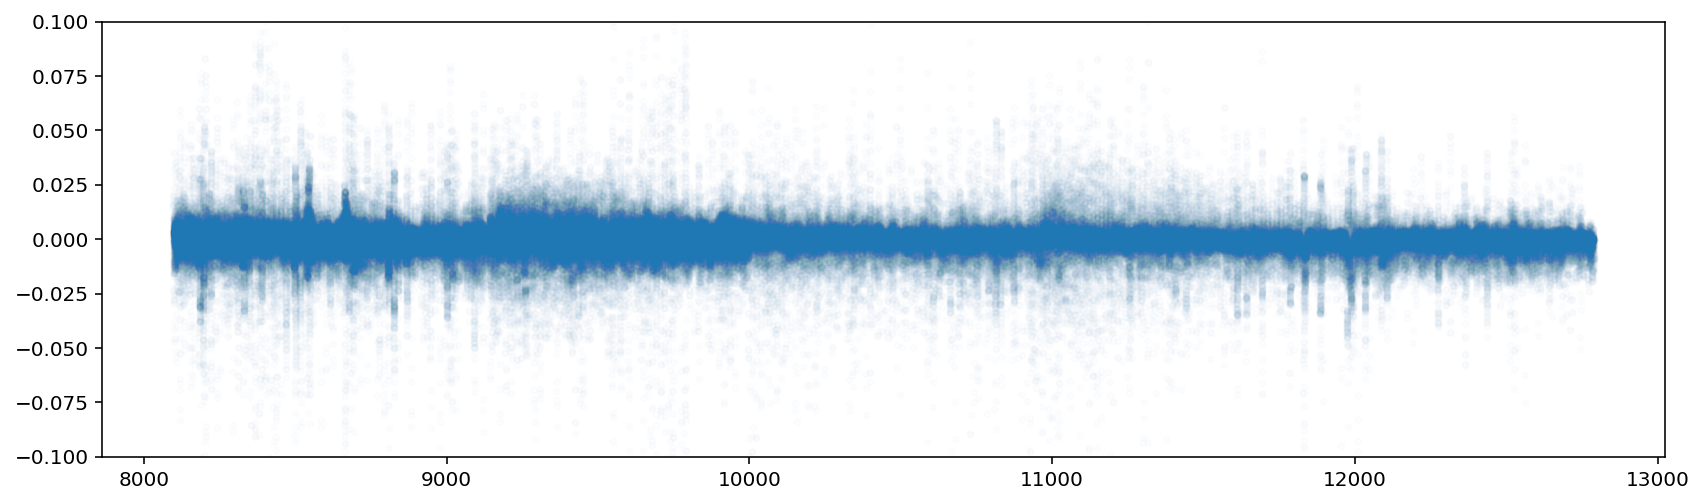

In [31]:
plt.figure(figsize=(14, 4))
plt.plot(wl, residual, '.', alpha=0.01)
plt.ylim(-0.1, 0.1)

Let's pick specific lines and drill down on them:

In [32]:
def sparse_pseudo_Voigt_model(emulator):
    """A sparse pseudo-Voigt model

    Note:
        Almost the same as the base class implementation, may want to refactor

    Returns:
        (torch.tensor): the 1D generative spectral model destined for backpropagation parameter tuning
    """
    fwhm_G = 2.3548 * torch.exp(emulator.sigma_widths).unsqueeze(1)
    fwhm_L = 2.0 * torch.exp(emulator.gamma_widths).unsqueeze(1)
    fwhm = emulator._compute_fwhm(fwhm_L, fwhm_G)
    eta = emulator._compute_eta(fwhm_L, fwhm)

    flux_2D = torch.exp(emulator.amplitudes).unsqueeze(1) * (
        eta
        * emulator.lorentzian_line(
            emulator.lam_centers.unsqueeze(1),
            torch.exp(emulator.gamma_widths).unsqueeze(1),
            emulator.wl_2D,
        )
        + (1 - eta)
        * emulator.gaussian_line(
            emulator.lam_centers.unsqueeze(1),
            torch.exp(emulator.sigma_widths).unsqueeze(1),
            emulator.wl_2D,
        )
    )

    return flux_2D

In [37]:
with torch.no_grad():
    flux_2D = sparse_pseudo_Voigt_model(emulator)

## Pick a single line to drill down on

In [62]:
ii = 1234

In [158]:
sorted_inds_amplitude = np.argsort(state_dict_post['gamma_widths'])

In [178]:
jj = -1

In [230]:
jj-=1
ii = sorted_inds_amplitude[jj]

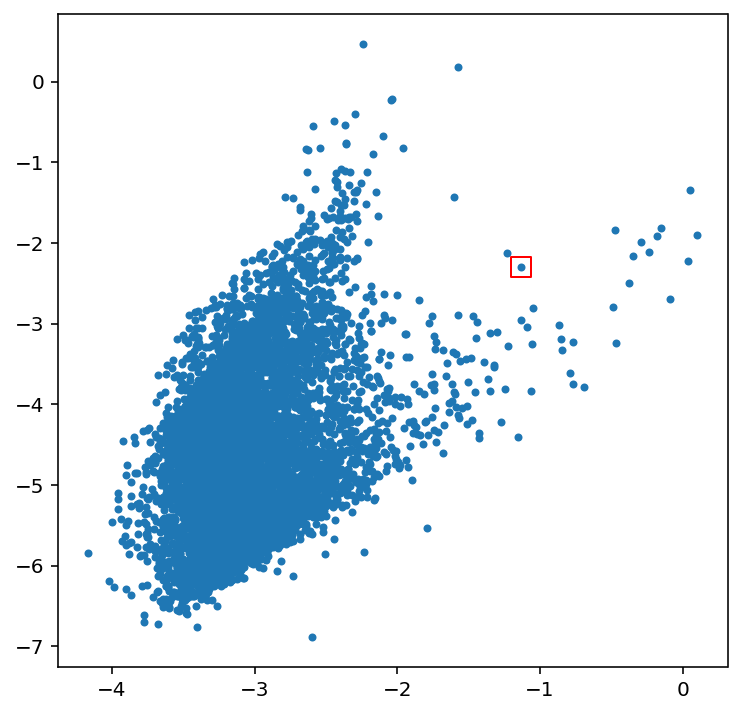

In [231]:
plt.figure(figsize=(6,6))
plt.plot(state_dict_post['gamma_widths'], state_dict_post['amplitudes'], '.');


plt.scatter(state_dict_post['gamma_widths'][ii], state_dict_post['amplitudes'][ii], 
            ec='r', fc = 'none', marker='s', s=100, zorder=10);

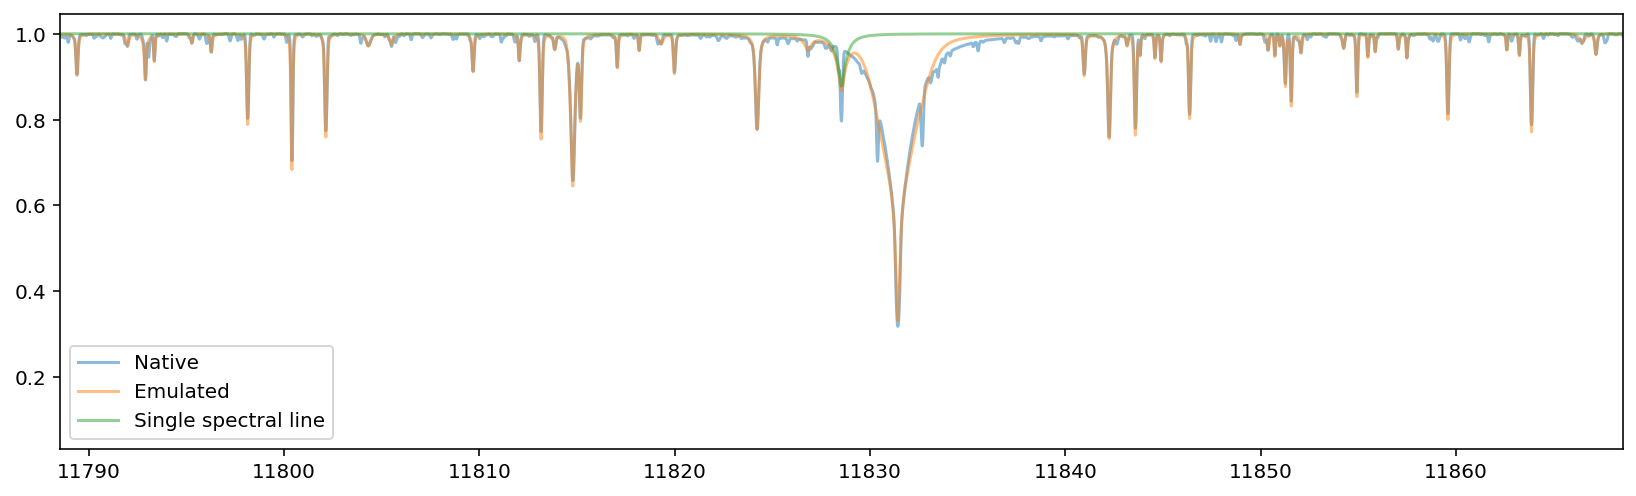

In [233]:
plt.figure(figsize=(14, 4))
plt.plot(wl, flux, alpha=0.5, label = 'Native')
plt.plot(wl, spec_out, alpha=0.5, label = 'Emulated')

plt.plot(emulator.wl_2D[ii, :], 1-flux_2D[ii, :], alpha=0.5, label='Single spectral line')
plt.xlim(emulator.wl_2D[ii, :].min()+20, emulator.wl_2D[ii, :].max()-20)
plt.legend();